# Generalized Advantage Estimation

## Hyperparameters

In [1]:
from utils.hyperparameters import Config

config = Config()

# meta info
config.algo = 'a2c'
config.env_id = 'BreakoutNoFrameskip-v4'
config.seed = None
config.inference = False
config.print_threshold = 100
config.save_threshold = 1000
config.render = False

# preprocessing
config.stack_frames = 4
config.adaptive_repeat = [4]
config.s_norm = 255.0
config.sticky_actions = 0.0

# Learning Control Variables
config.max_tsteps  = int(1e7)
config.learn_start = 0
config.num_envs    = 16
config.update_freq = 5
config.lr          = 7e-4
config.use_lr_schedule = True
config.grad_norm_max = 0.5
config.gamma = 0.99

# RMSProp params
config.rms_alpha = 0.99
config.rms_eps = 1e-5

#Recurrent control
config.policy_gradient_recurrent_policy = False
config.gru_size = 512

# A2C Controls
config.entropy_loss_weight=0.01
config.value_loss_weight=0.5

# GAE Controls
config.use_gae = True
config.gae_tau = 0.95

## Rollout Storage

In [2]:
from utils.RolloutStorage import RolloutStorage as Storage

class RolloutStorage(Storage):
    def __init__(self, num_steps, num_processes, obs_shape, action_space, state_size, device, USE_GAE=True, gae_tau=0.95):
        super(RolloutStorage, self).__init__(num_steps, num_processes, obs_shape, action_space, state_size, device, USE_GAE, gae_tau)

    def compute_returns(self, next_value, gamma):
        if self.gae:
            self.value_preds[-1] = next_value
            gae = 0
            for step in reversed(range(self.rewards.size(0))):
                delta = self.rewards[step] + gamma * self.value_preds[step + 1] * self.masks[step + 1] - self.value_preds[step]
                gae = delta + gamma * self.gae_tau * self.masks[step + 1] * gae
                self.returns[step] = gae + self.value_preds[step]
        else:
            self.returns[-1] = next_value
            for step in reversed(range(self.rewards.size(0))):
                self.returns[step] = self.returns[step + 1] * \
                    gamma * self.masks[step + 1] + self.rewards[step]

# Agent (Again)

In [3]:
from agents.A2C import Agent as A2C

class Agent(A2C):
    def __init__(self, static_policy=False, env=None, config=None, log_dir='/tmp/gym', tb_writer=None):
        super(Agent, self).__init__(config=config, env=env, log_dir=log_dir, tb_writer=tb_writer)

        self.rollouts = RolloutStorage(self.config.update_freq , self.config.num_envs,
            self.num_feats, self.envs.action_space, self.q_net.state_size,
            self.config.device, config.use_gae, config.gae_tau)

## Training Loop

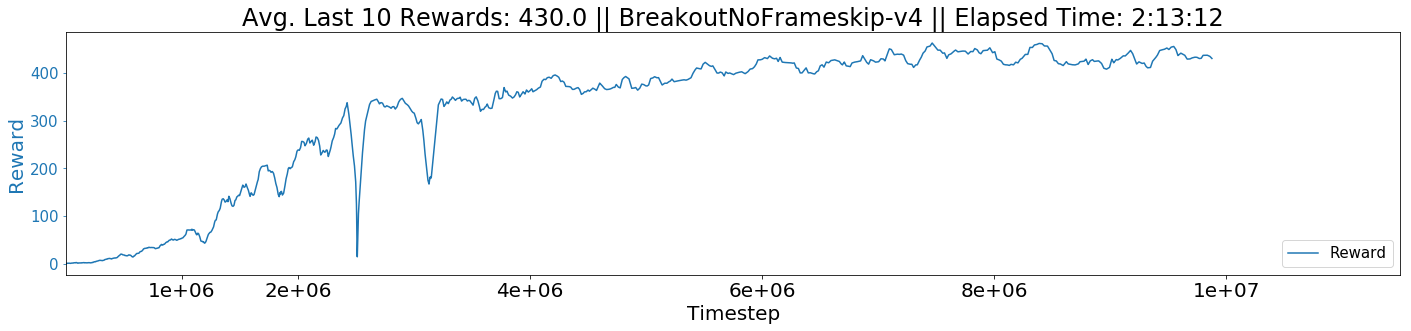

In [4]:
from train import train 
%matplotlib inline

train(config, Agent, ipynb=True)